<h1 style="text-align:center;"> The World Happiness Report </h1>

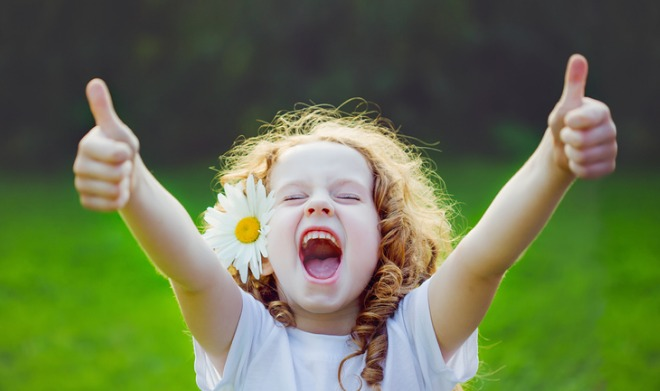

The report primarily uses data from the Gallup World Poll. Each annual report is available to the public to download on the World Happiness Report website. (Wikipedia)
 

The World Happiness Report uses markers to indicate the happiness of each country. It is collected to create a "Ladder Score" and then it is eventually changed to include a "Dystopia + residual" score. The main indicators include...

- GDP per capita
- Social Support
- Life Expectancy
- Freedom of Life Choices
- Generosity
- Perception of Corruption


The 2020 World Happiness Report, released on March 20, 2020, ranks 156 countries based on an average of three years of surveys between 2017 and 2019. The 2020 report especially focuses on the environment – social, urban, and natural, and includes links between happiness and sustainable development. (Wikipedia)

***

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sns
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
happy = pd.read_csv("/kaggle/input/world-happiness-report-2021/world-happiness-report-2021.csv")

In [ ]:
happy.head()

<h1>Any missing values?</h1>

In [ ]:
happy.isna().sum()

In [ ]:
# how many countries?
happy['Country name'].value_counts()

# Some *GRAPHS* to get us started

In [ ]:
sns.set_theme()

sns.relplot(
    data=happy,
    x='Ladder score', 
    y='Healthy life expectancy', 
    hue='Regional indicator')

Well, this is clear. Western Europe does a great job as a happiness indicator. However, i fyou look closely you can see that North America and ANZ probably have a better overall happiness score. 

I wanna take a closer look at who the top 25 countries are in terms of <code> Healthy life expectancy </code> and the <code> Ladder score </code>

In [ ]:
# seperate out the top 25
top_25 = happy[:25]

g = sns.relplot(
    data=top_25,
    x='Ladder score', 
    y='Healthy life expectancy',
    hue='Regional indicator')

In [ ]:
print(top_25['Regional indicator'].value_counts())
print(happy['Regional indicator'].value_counts())

Western Europe looks like quite a nice place to be, but we'll have to compare the total countries versus the top_25 countries. 4 out of 4 is just as good as 15 out of 15. 

In [ ]:
g = sns.lmplot(x='Logged GDP per capita',
              y='Social support',
              hue='Regional indicator', 
              col='Regional indicator',
              col_wrap=3,
              data=happy, 
              height=6)

The scores in both East Asia and North America and ANZ of **Social Support actually goes down when the GDP per capita increases.** That's a bit strange. I guess it's shows us that money will "buy happiness" up to a certain amount. But that also doesn't help us identify why Western Europe is doing so well. 

In [ ]:
sns.set_theme(style="white")
ax = sns.heatmap(happy[happy.columns[13:19]].corr()).set_title("All Countries")

In [ ]:
sns.set_theme(style="white")
ax = sns.heatmap(top_25[top_25.columns[13:19]].corr()).set_title("'Happiest' 25 Countries")

A quick look at these graphs shows us that once the GDP, Healthy Life Style, and Social Interactions are met, then people tend to focus more on extrernal things like **Perceptions of corruption**. That fits nicely into...
- Maslow's Hierarchy of Needs

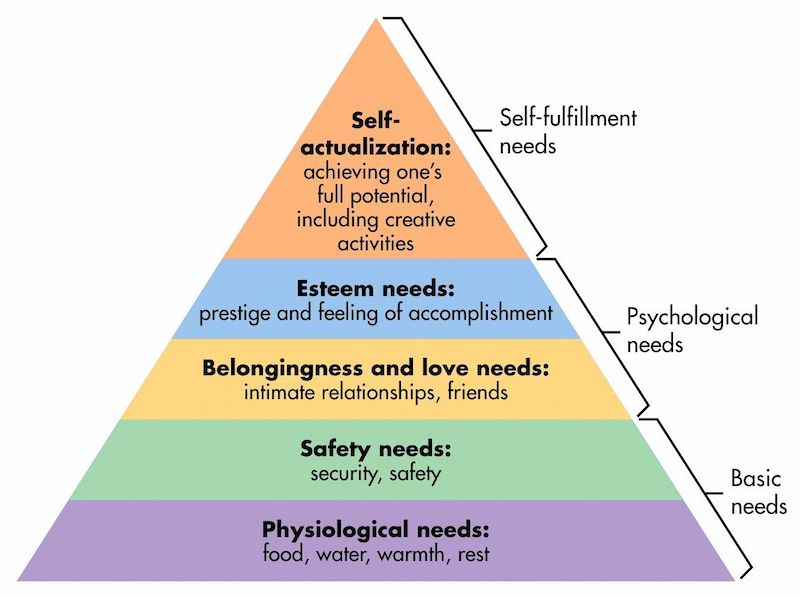

<h1> TensorFlow: Basic Regression </h1>

We'll test a few models to see which one does the best in this situation. We'll take the attributes and use a regression to predict the output of the "happiness" scale. I chose the "Ladder score" as the output variable. 
- single input
- linear model
- dnn model (single input)
- dnn model (multiple input)

In [ ]:
train_dataset = happy.sample(frac=0.8, random_state=0)
test_dataset = happy.drop(train_dataset.index)

<h3> Let's take a look at the data </h3>

In [ ]:
sns.pairplot(train_dataset[['Logged GDP per capita', 'Social support', 
                            'Healthy life expectancy', 'Freedom to make life choices', 
                           'Generosity', 'Perceptions of corruption']], diag_kind='kde')

In [ ]:
train_dataset.describe().transpose()

<h2> Separate the Target Value <code>'Ladder score'</code> from the labels

In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

# we'll also drop these values that we don't need and will skew the results
train_features.drop(columns=['Country name', 'Regional indicator', 
                             'Standard error of ladder score', 'upperwhisker', 'lowerwhisker',
                            'Ladder score in Dystopia', 'Dystopia + residual'], inplace=True)
test_features.drop(columns=['Country name', 'Regional indicator', 
                             'Standard error of ladder score', 'upperwhisker', 'lowerwhisker',
                            'Ladder score in Dystopia', 'Dystopia + residual'], inplace=True)

train_labels = train_features.pop('Ladder score')
test_labels = test_features.pop('Ladder score')

It appears the Columns have already been normalized by using the "Explained by:" characteristic. We'll take that at face value and move onto the next parts. However, we'll run a Normalization through the data as well to make sure we've done our part. It shouldn't affect the predictions. 

In [ ]:
# first, let's get a whole dataset normalizer
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))

In [ ]:
print(normalizer.mean.numpy())

In [ ]:
first = np.array(train_features[:1])

In [ ]:
with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

<h2> 1. Linear Regression Model </h2>

I'm choosing Life Expectancy as our single-variable linear regression. It seems to be an okay indicator of happiness. 

In [ ]:
life_exp = np.array(train_features['Explained by: Healthy life expectancy'])

life_exp_normalizer = preprocessing.Normalization(input_shape=[1,])
life_exp_normalizer.adapt(life_exp)

In [ ]:
#and now the sequential model build

life_exp_model = tf.keras.Sequential([
    life_exp_normalizer, 
    layers.Dense(units=1)
])

life_exp_model.summary()

This model predicts the <code> Ladder Score </code> from <code> Life Expectancy </code>

In [ ]:
life_exp_model.predict(life_exp[:10])

In [ ]:
life_exp_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [ ]:
%%time
history = life_exp_model.fit(
    train_features['Explained by: Healthy life expectancy'], train_labels, 
    epochs=100, 
    verbose=0, 
    validation_split=0.2)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Life Expectancy]')
    plt.legend()
    plt.grid(True)

In [ ]:
plot_loss(history)

In [ ]:
test_results = {}

test_results['life_exp_model'] = life_exp_model.evaluate(
    test_features['Explained by: Healthy life expectancy'], 
    test_labels, verbose=0)

In [ ]:
x = tf.linspace(0.0, 1, 150)
y = life_exp_model.predict(x)

In [ ]:
def plot_life_exp(x, y):
    plt.scatter(train_features['Explained by: Healthy life expectancy'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Life Expectancy')
    plt.ylabel('Happiness Score')
    plt.legend()


In [ ]:
plot_life_exp(x,y)

<h2> Multiple Inputs (Linear Regression) </h2>

In [ ]:
linear_model = tf.keras.Sequential([
    normalizer, 
    layers.Dense(units=1)
])

In [ ]:
linear_model.predict(train_features[:10])

In [ ]:
linear_model.layers[1].kernel

In [ ]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [ ]:
%%time
history = linear_model.fit(
    train_features, 
    train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2)

In [ ]:
plot_loss(history)

In [ ]:
test_results['linear_model'] = linear_model.evaluate(
test_features, test_labels, verbose=0)

<h2> DNN Regression Model </h2>

In [ ]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
  ])
    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [ ]:
dnn_life_exp_model = build_and_compile_model(life_exp_normalizer)

In [ ]:
dnn_life_exp_model.summary()

In [ ]:
%%time
history = dnn_life_exp_model.fit(
    train_features['Explained by: Healthy life expectancy'], train_labels, 
    validation_split=0.2,
    verbose=0, 
    epochs=100)

In [ ]:
plot_loss(history)

In [ ]:
x = tf.linspace(0.0, 1, 150)
y = dnn_life_exp_model.predict(x)

In [ ]:
plot_life_exp(x,y)

In [ ]:
test_results['dnn_life_exp_model'] = dnn_life_exp_model.evaluate(
    test_features['Explained by: Healthy life expectancy'], 
    test_labels, 
    verbose=0)

<h3> Full Model - using all the inputs </h3> 
Hopefully this will improve the performance. 

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

In [ ]:
%%time
history = dnn_model.fit(
    train_features, 
    train_labels, 
    validation_split=0.2,
    verbose=0,
    epochs=100)

In [ ]:
plot_loss(history)

In [ ]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [ ]:
pd.DataFrame(test_results, index=['Mean Absolute Error [Ladder score]']).T

In [ ]:
group = ['yes', 'no', 'see']

for x in group: 
    print(x)

In [ ]:
test_predictions = dnn_model.predict(test_features).flatten()
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Happiness Score]')
plt.ylabel('Predictions [Happiness Score]')
plt.title('DNN Model')
lims = [2, 9]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [ ]:
test_predictions = linear_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Happiness Score]')
plt.ylabel('Predictions [Happiness Score]')
plt.title('Linear Model')
lims = [2, 9]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Happiness Score]')
_ = plt.ylabel('Count')

It sure appears that the linear model has the best mean absolute error score here. Sometimes a DNN model can overfit, and I think that's what has happened here. The data only include 119 countries, so it's not a lot of data for a machine learning algorithm. 

Sources: 

https://en.wikipedia.org/wiki/World_Happiness_Report